In [ ]:
import numpy as np
from abc import ABC, abstractmethod

In [ ]:
def validate_node(func):
  def wrapper(node):
    try:
      if node.size:
        return func(node)
      else:
        return 0
    except AttributeError:
      raise 

  return wrapper



class Criterion:

  @staticmethod
  @validate_node
  def gini(node: np.ndarray):
    
    _, counts = np.unique(node, return_counts=True)
    return 1- np.sum( (counts/np.sum(counts)**2 )) # numpy vectors

  @staticmethod
  @validate_node
  def entropy(node: np.ndarray):
    
    _, counts = np.unique(node, return_counts=True)
    n_instances=np.sum(counts)
    log=np.log2(counts/n_instances)
    return -np.sum(  counts/n_instances* np.nan_to_num(log,neginf=0))

  @staticmethod
  @validate_node
  def RMSE(node: np.ndarray):
    

    return np.sqrt( Criterion.MSE(node) )


  @staticmethod
  @validate_node
  def MSE(node: np.ndarray):
    
  
    y_mean=np.mean(node)
    return np.sum( (node- y_mean)**2 )




In [ ]:
import numpy as np

CRITERIA_CLASSIFIER={'gini':Criterion.gini,'entropy':Criterion.entropy}
CRITERIA_REGRESSOR={'RMSE':Criterion.RMSE,'MSE':Criterion.MSE}


class DecisionTreeBase:

  def __init__(self,max_depth: int=np.iinfo(np.int32).max) ->None:

    #'min_samples_split':min_samples_split, 'min_samples_leaf':min_samples_leaf
    params={ 'max_depth':max_depth}
    final_params=self.validate_params(  params  )

    self.max_depth=final_params['max_depth']
    #self.min_samples_split=final_params['min_samples_split']
    #self.min_samples_leaf=final_params['min_samples_leaf']
    self.task_type=None
    self.criterion=None
    self.is_fitted=False

  def set_criterion(self,criterion):
    
    if self.task_type =='regression':
      criterion= CRITERIA_REGRESSOR.get(criterion,None)
      if criterion:
        self.criterion =criterion
        #print('Criterion set for regression', self.criterion)

      else:
        print('Invalid criterion chosen for regression, criterion set to default MSE')
        self.criterion=Criterion.MSE
      
    elif self.task_type=='classification':
      criterion= CRITERIA_CLASSIFIER.get(criterion,None)

      if criterion:
        self.criterion =criterion
      else:
        print('Invalid criterion chosen for classification, criterion set to default gini')
        self.criterion=Criterion.gini
      
    else:
      raise ValueError('Invalid task type chosen, make sure to use derived class')


  def check_param_value(self,param):

    if isinstance(param,(int,np.integer)):
      if param>=0:
        return True
      else:
        print('Invalid parameter value, check if it is >= 0, parameter set to maximum value ')
    else:
      print('Invalid parameter type, check if it is int or numpy.integer, parameter set to maximum value ')
  
    return False

  def validate_params(self,params: dict):

    final_params={}
    for param,value in params.items():
      if self.check_param_value(value):
        final_params[param]=value
      else:
        final_params[param]=np.iinfo(np.int32).max

    return final_params

        
  def fit( self, X: np.ndarray, y: np.ndarray, check_input = True) -> None:
    
    if check_input:
      try:
        X=self.check_input(X,'X')
        y=self.check_input(y,'y')
      except ValueError:
        raise

    if self.task_type=='regression':
      #print(f'Fit in decisiontree started, criterion: {self.criterion}')
      self.node= NodeRegressor( X, y,self.max_depth,0,self.criterion)#, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf
      self.is_fitted=True

    elif self.task_type=='classification':
      possible_classes=np.unique(y)
      self.node= NodeClassifier( X, y, possible_classes, self.max_depth,0,self.criterion ) # building tree
      self.is_fitted=True

    else:
      raise ValueError('Invalid task type chosen, make sure to use derived class')



  def predict( self, X:np.ndarray ) -> np.ndarray:
    X=self.check_input(X,'X to predict')
    return np.array([  self.node.predict(x) for x in X]).reshape(-1,1)

  def printTree( self ) -> None:
    self.node.print()

  def check_input( self, X , input_name):

    if isinstance(X,(list,)):
      return np.array(X).reshape(-1,1)
      
    elif isinstance(X,(np.ndarray,)):
      shape=X.shape

      try:
        n_instances, n_features= shape
      except ValueError:
        n_instances,  = shape
        n_features=None

      if n_features == None:
        X=X.reshape((-1,1))
      return X

    else: 
      raise ValueError(f'Invalid {input_name}, please check if it is a list or a numpy.ndarray')
        


  def is_classifier(self):
    return getattr(self,'task_type', None) =='classication'

  def is_regressor(self):
    return getattr(self,'task_type',None) == 'regression'

  


In [ ]:
class DecisionTreeClassifier(DecisionTreeBase):
  def __init__(self, criterion='gini',max_depth: int=np.iinfo(np.int32).max) ->None:
    super().__init__( max_depth=max_depth)
    self.task_type='classification'
    super().set_criterion(criterion=criterion)



class DecisionTreeRegressor(DecisionTreeBase):
  def __init__(self, criterion='MSE',max_depth: int=np.iinfo(np.int32).max) ->None:
    
    super().__init__( max_depth=max_depth)
    self.task_type='regression'
    super().set_criterion(criterion=criterion)
    


In [ ]:
class NodeBase:
  def __init__(self,X,y,criterion,max_depth=np.inf,depth=0):

    self.X=X
    self.y=y
    self.children=None
    self.final_value=None
    self.is_leaf=False
    self.max_depth=max_depth
    self.depth=depth
    self.criterion=criterion
    self.cost=self.criterion(y)

  def print(self) -> None:
    '''Implemented in derived classes'''
    pass


  def build(self):
    shape=self.X.shape
    left_indices=None
    min_error_feature=None
    min_error_feature_value=None
    min_cost=self.cost

    try:   
      n_instances, n_features= shape
    except ValueError:
      n_instances, =shape
      n_features=1
      
    for k in range(n_features): # check in every feature

      X_k=self.X[:,k]  # feature values
      X_k_unique=np.unique(X_k) # unique values

      for instance in X_k_unique:
        
        left_indices_current=np.where(X_k < instance ) # indexes of instances <= current instance - left indexes, 
        mask = np.zeros(len(self.y),dtype=bool)
        mask[left_indices_current] = True
        # split y into possible children
        left=self.y[mask]
        right=self.y[~mask] 
        curr_cost=len(left)/len(self.y)*self.criterion(left )  +  len(right)/len(self.y)*self.criterion(right)
        
        if curr_cost < min_cost: # smaller impurity
          min_cost=curr_cost
          left_indices=left_indices_current
          min_error_feature=k
          min_error_feature_value=instance

    #after all features and their values have been checked
    if min_cost<self.cost: # if split reduces cost

      self.min_error_feature=min_error_feature
      self.min_error_value=min_error_feature_value
      mask = np.zeros(len(self.y),dtype=bool)
      mask[left_indices] = True
      self.is_leaf=False

      if self.task_type=='regression':
        self.children=( NodeRegressor(self.X[mask,:] ,self.y[mask],self.max_depth,self.depth+1,self.criterion ),  NodeRegressor(self.X[~mask,:] ,self.y[~mask],self.max_depth,self.depth+1,self.criterion ) )
      else:
        self.children=( NodeClassifier(self.X[mask,:] ,self.y[mask],self.possible_classes,self.max_depth,self.depth+1,self.criterion ),  NodeClassifier(self.X[~mask,:] ,self.y[~mask],self.possible_classes,self.max_depth,self.depth+1,self.criterion ) )
    
    else: # no split, impurity wont be reduced
      self.is_leaf=True
      

  def predict(self,X):

    if self.is_leaf:
      return self.final_value
    else:
      # if self.validate_input(X):
            
      if X[self.min_error_feature] < self.min_error_value:
        return self.children[0].predict(X)
      else:
        return self.children[1].predict(X)
    

class NodeClassifier(NodeBase):

  def __init__(self,X,y,possible_classes,max_depth,depth,criterion):
    
    super().__init__(X,y,criterion,max_depth,depth)
    self.possible_classes=possible_classes
    self.task_type='classification' # needed for parent class

    classes, counts = np.unique(y, return_counts=True) # classes in node and their counts
    
    self.final_value=classes[np.argmax(counts)]
    value=np.zeros(len(possible_classes) )
    value[classes]=counts
    self.value=value

    if self.depth < max_depth:
      self.build()
    else:
      self.is_leaf=True    

  def print(self) -> None:

    print(f'Possible classes:{self.possible_classes}')
    print(f'Value:{self.value}')
    print(f'Samples: {len(self.X)}')
    print(f'Impurity:{self.cost}')
    print(f'Depth: {self.depth}')
    print(f'Class:{self.final_value}')
      
    if self.is_leaf:
      print("is Leaf")
    print('\n\n')

    if self.children is not None:
      self.children[0].print()
      self.children[1].print()

    return



class NodeRegressor(NodeBase):

  def __init__(self,X,y,max_depth,depth,criterion):
    super().__init__(X,y,criterion,max_depth,depth)
    self.task_type='regression'
    self.final_value=np.mean(y)

    if self.depth < max_depth:
      self.build()
    else:
      self.is_leaf=True   
    
  def print(self) -> None:

    print(f'Value:{self.final_value}')
    print(f'Samples: {len(self.X)}')
    print(f'Cost:{self.cost}')
    print(f'Depth: {self.depth}')

    if self.is_leaf:
      print("is Leaf")
    print('\n\n')

    if self.children is not None:
      self.children[0].print()
      self.children[1].print()

    return

### Classification example

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from  sklearn.metrics import accuracy_score

iris=datasets.load_iris()

X = iris["data"][:, 2:] 
y=iris.target
y=y.reshape((-1,1))
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)



In [ ]:
tree_clf=DecisionTreeClassifier(max_depth=15)
tree_clf.fit(X_train,y_train)

In [ ]:
tree_clf.printTree()

In [ ]:
y_pred=tree_clf.predict(X_val)

In [ ]:
accuracy_score(y_pred,y_val)

0.9666666666666667

### Regression example

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)



In [ ]:
tree_reg1=DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X_train,y_train)
tree_reg2=DecisionTreeRegressor(max_depth=3)
tree_reg2.fit(X_train,y_train)

In [ ]:
y_pred1=tree_reg1.predict(X_val)
mean_squared_error(y_val,y_pred1)

In [ ]:
y_pred2=tree_reg2.predict(X_val)
mean_squared_error(y_val,y_pred2)

In [ ]:
y.mean()

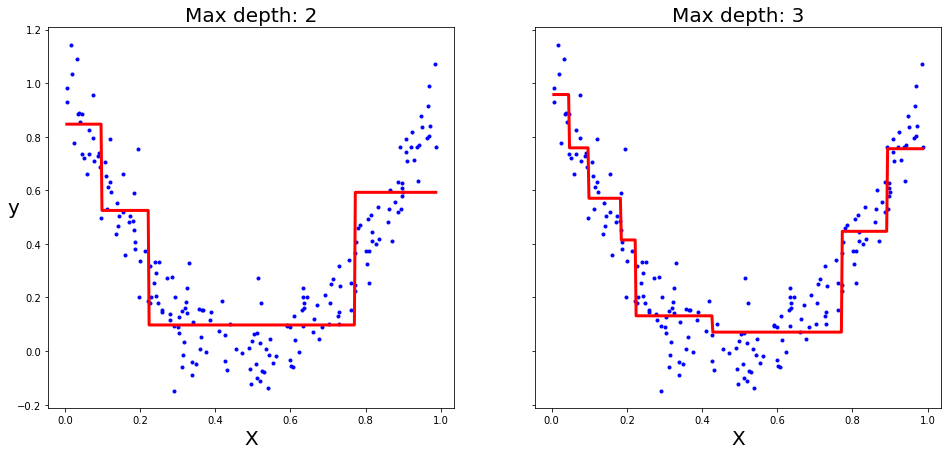

In [ ]:
import matplotlib.pyplot as plt

def plot_regression(regressor, X,y,max_depth=None,y_label=None):

  X_temp=np.linspace(X.min(), X.max(),num=len(X)*2)
  y_temp=regressor.predict(X_temp)
  plt.plot(X,y,'b.')
  plt.plot(X_temp,y_temp,'r', linewidth=3)
  plt.xlabel("X",fontsize=20)
  if y_label:
    plt.ylabel(y_label,fontsize=20,rotation=0)
  if max_depth:
    plt.title(f'Max depth: {max_depth}',fontsize=20)



fig,axes=plt.subplots(ncols=2,sharey=True, figsize=(16,7) )
plt.sca(axes[0])
plot_regression(tree_reg1,X,y,2,'y')
plt.sca(axes[1])
plot_regression(tree_reg2,X,y,3)

  

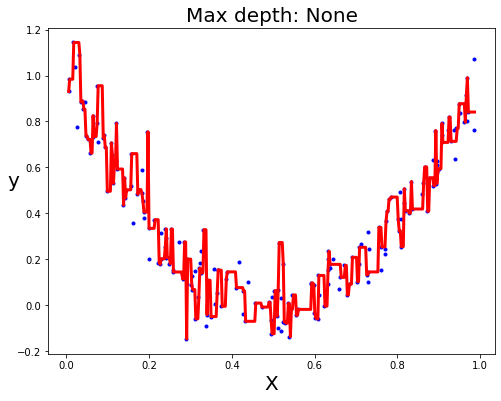

In [ ]:
tree_reg3=DecisionTreeRegressor()
tree_reg3.fit(X_train,y_train)
plt.figure(figsize=(8,6))
plot_regression(tree_reg3,X,y,'None','y')
